# Diabetic Retinopathy with Machine Learning

## Loading the dataset

In [ ]:
url = '../data/17006903.csv'

In [ ]:
names = ['quality', 'retinal_abnormality']
names.extend(['feat1_{}'.format(str(i)) for i in range(6)])
names.extend(['feat2_{}'.format(str(i)) for i in range(8)])
names.extend(['dist_of_macula_and_optic_disc', 'diameter_of_optic_disc', 'am_fm_classification', 'dr'])
len(names)

20

In [ ]:
import pandas as pd

dataset = pd.read_csv(url)
dataset.columns = names
dataset.head()

,quality,retinal_abnormality,feat1_0,feat1_1,feat1_2,feat1_3,feat1_4,feat1_5,feat2_0,feat2_1,feat2_2,feat2_3,feat2_4,feat2_5,feat2_6,feat2_7,dist_of_macula_and_optic_disc,diameter_of_optic_disc,am_fm_classification,dr
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [ ]:
dataset.shape

(1150, 20)

## Preprocessing

Looking for missing values:

In [ ]:
dataset.isnull().values.any()

False

There is no missing value in the dataset

Checking if are there any columns which only contain 1 value:

In [ ]:
dataset.nunique()

quality                             2
retinal_abnormality                 2
feat1_0                           110
feat1_1                           104
feat1_2                            99
feat1_3                            91
feat1_4                            84
feat1_5                            69
feat2_0                          1140
feat2_1                          1140
feat2_2                          1129
feat2_3                          1031
feat2_4                           794
feat2_5                           578
feat2_6                           415
feat2_7                           351
dist_of_macula_and_optic_disc    1131
diameter_of_optic_disc           1109
am_fm_classification                2
dr                                  2
dtype: int64

All the columns have at least 2 type of values, thus nothing to remove.

Looking for duplicate rows

In [ ]:
dups = dataset.duplicated()
print(dups.any())
print(dataset[dups].shape)
dataset[dups]

True
(5, 20)


,quality,retinal_abnormality,feat1_0,feat1_1,feat1_2,feat1_3,feat1_4,feat1_5,feat2_0,feat2_1,feat2_2,feat2_3,feat2_4,feat2_5,feat2_6,feat2_7,dist_of_macula_and_optic_disc,diameter_of_optic_disc,am_fm_classification,dr
171,1,1,49,48,45,40,37,26,26.347993,13.666809,2.556415,0.192468,0.000000,0.000000,0.000000,0.000000,0.557765,0.113308,0,1
627,1,1,70,68,64,63,58,38,66.751648,32.166708,14.077515,3.378666,0.558174,0.063925,0.007796,0.000000,0.506050,0.101344,0,1
680,1,1,66,65,65,64,63,53,11.103445,4.009015,0.397164,0.129273,0.076318,0.052955,0.035823,0.018690,0.543196,0.096565,0,1
708,1,1,35,33,32,31,31,26,6.193941,1.625616,0.108061,0.000000,0.000000,0.000000,0.000000,0.000000,0.517101,0.084570,0,1
782,1,1,43,42,42,40,39,34,21.612661,9.669272,0.903438,0.274757,0.128841,0.082272,0.066749,0.058987,0.541183,0.099347,0,1


There are 5 duplicated rows which needs to be removed.

Removing the duplicated values, and checking if all of them deleted succesfully

In [ ]:
dataset.drop_duplicates(inplace=True)
dataset.duplicated().any()

False

Count the rows where the image's quality is bad (quality != 1)

In [ ]:
dataset[dataset.quality != 1].shape

(4, 20)

4 rows found, removing them:

In [ ]:
dataset = dataset[dataset.quality == 1]
dataset.shape

(1141, 20)

After all the records removed where the image's quality was bad the `quality` column become unnecessary. 

In [ ]:
dataset.drop(['quality'], axis=1, inplace=True)
dataset.shape

(1141, 19)

Checking how balanced the dataset is


Counting the positives and negatives

In [ ]:
dataset[dataset.dr == 1].shape

(606, 19)

In [ ]:
dataset[dataset.dr == 0].shape

(535, 19)

## Training

In [ ]:
df = dataset
df

,retinal_abnormality,feat1_0,feat1_1,feat1_2,feat1_3,feat1_4,feat1_5,feat2_0,feat2_1,feat2_2,feat2_3,feat2_4,feat2_5,feat2_6,feat2_7,dist_of_macula_and_optic_disc,diameter_of_optic_disc,am_fm_classification,dr
0,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1,16,16,15,14,12,8,158.177307,84.865487,51.253664,11.283321,1.857293,0.019520,0.006832,0.001952,0.533177,0.104430,1,0
1146,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1148,0,49,48,48,45,43,33,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def normalize_datasets(train_df, test_df):
  scaler = MinMaxScaler()

  ## Filtering out the boolean columns
  col_names =  names[2:-2]

  train_df_norm = train_df.copy()
  features = train_df_norm[col_names]

  scaler = scaler.fit(features.values)
  features = scaler.transform(features.values)
  train_df_norm[col_names] = features

  test_df_norm = test_df.copy()
  features = test_df_norm[col_names]
  features = scaler.transform(features.values)
  test_df_norm[col_names] = features

  return train_df_norm, test_df_norm

print("Defined the normalize_datasets function.")

Defined the normalize_datasets function.


In [ ]:
import datetime
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, DenseFeatures
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, Reduction

def create_model(learning_rate, metrics, feature_columns, regularization=False):                         
  model = Sequential()
  
  model.add(DenseFeatures(feature_columns))
  model.add(Dense(units=100, activation='relu', name='Hidden1'))
  if(regularization):
    model.add(Dropout(rate=0.05, name='Hidden2'))
  model.add(Dense(units=100, activation='relu', name='Hidden3'))
  model.add(Dense(units=1, activation='sigmoid', name='Output'))
    
  optimizer = Adam(lr=learning_rate)
  loss = BinaryCrossentropy(reduction=Reduction.NONE)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

  print("Defined the create_model function.")

In [ ]:
import numpy as np

def split_features_and_label(df):
  features = {name:np.array(value) for name, value in df.items()}
  label = np.array(features.pop(label_name))
  return features, label 

def train_model(model, train_df, test_df, num_of_epochs, label_name, batch_size=None):
  train_features, train_label = split_features_and_label(train_df)
  test_features, test_label = split_features_and_label(test_df)

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size, epochs=num_of_epochs, validation_data=(test_features, test_label), shuffle=True, verbose=1) 
  
  return  pd.DataFrame(history.history)

print("Defined the split_features_and_label and the train_model functions.")

Defined the split_features_and_label and the train_model functions.


In [ ]:
def make_plot(data_array, legend_array, plot_title, x_label, y_label):
  plt.figure(figsize=(10, 5))
  for item in data_array:
    plt.plot(item)
  plt.title(label=plot_title)
  plt.xlabel(xlabel=x_label)
  plt.ylabel(ylabel=y_label)
  plt.ylim((0, 1))
  plt.legend(legend_array, loc='upper left');

print("Defined the make_plot function.")

Defined the make_plot function.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cnf_matrix):
  class_names = [0,1]
  fig,ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks,class_names)
  plt.yticks(tick_marks,class_names)

  sns.heatmap(pd.DataFrame(cnf_matrix),annot=True,cmap="Blues",fmt="d",cbar=False)
  ax.xaxis.set_label_position('top')
  plt.tight_layout()
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label');
  plt.show()

print("Defined the plot_confusion_matrix function.")

Defined the plot_confusion_matrix function.


In [ ]:
def get_stats(model, test_df_norm, accuracy_array, fscore_array, precision_array, sensitivity_array, specificity_array, cnf_dict):
  x_test, y_test = split_features_and_label(df=test_df_norm)
  current_accuracy = model.evaluate(x_test, y_test)[1]
  accuracy_history_array.append(current_accuracy)

  predictions = model.predict(x_test)
  bin_predictions = tf.round(predictions).numpy().flatten()
  current_cnf = confusion_matrix(y_test, bin_predictions)
  cnf_history_array.append(current_cnf)

  tn = current_cnf[0][0]
  fp = current_cnf[0][1]
  fn = current_cnf[1][0]
  tp = current_cnf[1][1]
  cnf_dict['tn'] += tn
  cnf_dict['fp'] += fp
  cnf_dict['fn'] += fn
  cnf_dict['tp'] += tp

  accuracy = (tp + tn) / (tp + fp + tn + fn)
  fscore = (2 * tp) / ((2 * tp) + fn + fp)
  precision = tp / (tp + fp)
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  accuracy_array.append(accuracy)
  fscore_array.append(fscore)
  precision_array.append(precision)
  sensitivity_array.append(sensitivity)
  specificity_array.append(specificity)

In [ ]:
def print_stats(accuracy_array, fscore_array, precision_array, sensitivity_array, specificity_array, cnf_dict):
  n_accuracy = np.array(accuracy_array)
  n_fscore = np.array(fscore_array)
  n_precision = np.array(precision_array)
  n_sensitivity = np.array(sensitivity_array)
  n_specificity = np.array(specificity_array)


  accuracy = np.mean(n_accuracy)
  fscore = np.mean(n_fscore)
  precision = np.mean(n_precision)
  sensitivity = np.mean(n_sensitivity)
  specificity = np.mean(n_specificity)

  accuracy_percentage = accuracy * 100
  fscore_percentage = fscore * 100
  precision_percentage = precision * 100
  sensitivity_percentage = sensitivity * 100
  specificity_percentage = specificity * 100

  print('accuracy:\t{0:0.2f}%'.format(accuracy_percentage))
  print('f-score:\t{0:0.2f}%'.format(fscore_percentage))
  print('precision:\t{0:0.2f}%'.format(precision_percentage))
  print('sensitivity:\t{0:0.2f}%'.format(sensitivity_percentage))
  print('specificity:\t{0:0.2f}%'.format(specificity_percentage))
  cnf_matrix = [[cnf_dict['tn'], cnf_dict['fp']],
                [cnf_dict['fn'], cnf_dict['tp']]]
  plot_confusion_matrix(cnf_matrix)

In [ ]:
import tensorflow as tf
from tensorflow.feature_column import numeric_column, categorical_column_with_vocabulary_list, indicator_column

feature_columns = []

numeric_columns_to_add = ['feat1_0', 'feat1_1', 'feat1_2', 'feat1_3', 'feat1_4',
                          'feat1_5', 'feat2_0', 'feat2_1', 'feat2_2', 'feat2_3',
                          'feat2_4', 'feat2_5', 'feat2_6', 'feat2_7',
                          'dist_of_macula_and_optic_disc',
                          'diameter_of_optic_disc']
# numeric columns
for header in numeric_columns_to_add:
  feature_columns.append(numeric_column(header))

# indicator columns
am_fm_classification = categorical_column_with_vocabulary_list(key='am_fm_classification', vocabulary_list=[0, 1])
am_fm_classification_one_hot = indicator_column(categorical_column=am_fm_classification)
feature_columns.append(am_fm_classification_one_hot)

retinal_abnormality = categorical_column_with_vocabulary_list(key='retinal_abnormality', vocabulary_list=[0, 1])
retinal_abnormality_one_hot = indicator_column(categorical_column=retinal_abnormality)
feature_columns.append(retinal_abnormality_one_hot)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as pyplot

learning_rate = 0.01
num_of_epochs = 100
batch_size = 32
label_name = 'dr'
metrics = ['accuracy']

# initializing the history arrays
accuracy_history_array = []
cnf_history_array = []

history_array = []
accuracy_array = []
fscore_array = []
precision_array = []
sensitivity_array = []
specificity_array = []
cnf_dict = {}
cnf_dict['tn'] = 0
cnf_dict['fp'] = 0
cnf_dict['fn'] = 0
cnf_dict['tp'] = 0

history_reg_array = []
accuracy_reg_array = []
fscore_reg_array = []
precision_reg_array = []
sensitivity_reg_array = []
specificity_reg_array = []
cnf_reg_dict = {}
cnf_reg_dict['tn'] = 0
cnf_reg_dict['fp'] = 0
cnf_reg_dict['fn'] = 0
cnf_reg_dict['tp'] = 0

num_of_iterations = 10

# randomizing the values, splitting training/test dataset and trainig iterating num_of_iteartions times
for _ in range(num_of_iterations):
  # splitting and normalizing the dataset
  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
  train_df_norm, test_df_norm = normalize_datasets(train_df=train_df, test_df=test_df)

  #creating the model
  model = create_model(learning_rate=learning_rate, metrics=metrics, feature_columns=feature_columns, regularization=False)
  model_reg = create_model(learning_rate=learning_rate, metrics=metrics, feature_columns=feature_columns, regularization=True)
  # training the model
  history = train_model(model=model, train_df=train_df_norm, test_df=test_df_norm, num_of_epochs=num_of_epochs, label_name=label_name, batch_size=batch_size)
  history_reg = train_model(model=model_reg, train_df=train_df_norm, test_df=test_df_norm, num_of_epochs=num_of_epochs, label_name=label_name, batch_size=batch_size)
  
  # saving the history
  history_array.append(history)
  history_reg_array.append(history_reg)

  get_stats(
      model=model,
      test_df_norm=test_df_norm,
      accuracy_array=accuracy_array,
      fscore_array=fscore_array,
      precision_array=precision_array,
      sensitivity_array=sensitivity_array,
      specificity_array=specificity_array,
      cnf_dict=cnf_dict
      )
  get_stats(
      model=model_reg, 
      test_df_norm=test_df_norm,
      accuracy_array=accuracy_reg_array,
      fscore_array=fscore_reg_array,
      precision_array=precision_reg_array,
      sensitivity_array=sensitivity_reg_array,
      specificity_array=specificity_reg_array,
      cnf_dict=cnf_reg_dict
      )



Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
18/29 [=================>............] - ETA: 0s - loss: 0.6897 - accuracy: 0.5372 WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'retinal_abnormality': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=int64>, 'feat1_0': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float32>, 'feat1_1': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float32>, 'feat1_2': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float32>, 'feat1_3': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float32>, 'feat1_4': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float32>, 'feat1_5': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float32>, 'feat2_0': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float32>, 'feat2_1': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=float32>, 'feat2_2': <tf.T

In [ ]:
n_accuracy_history = np.array(accuracy_history_array)
mean_accuracy = n_accuracy_history.mean()
print('Mean accuracy: {}'.format(mean_accuracy))

Mean accuracy: 0.7451965153217316


accuracy:	73.84%
f-score:	71.80%
precision:	84.66%
sensitivity:	63.17%
specificity:	86.23%


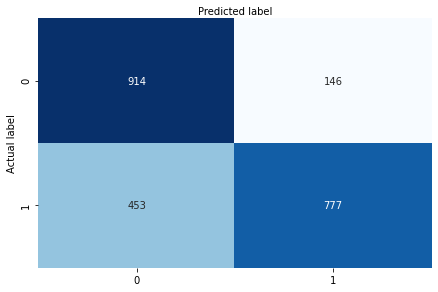

In [ ]:
print_stats(
    accuracy_array=accuracy_array,
    fscore_array=fscore_array,
    precision_array=precision_array,
    sensitivity_array=sensitivity_array,
    specificity_array=specificity_array,
    cnf_dict=cnf_dict
    )

accuracy:	75.20%
f-score:	75.13%
precision:	81.40%
sensitivity:	70.33%
specificity:	80.85%


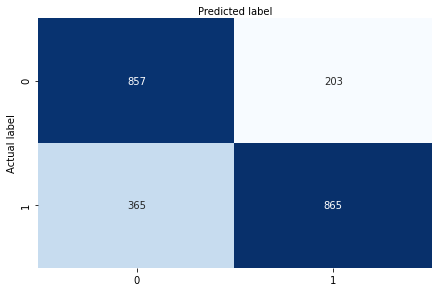

In [ ]:
print_stats(
    accuracy_array=accuracy_reg_array,
    fscore_array=fscore_reg_array,
    precision_array=precision_reg_array,
    sensitivity_array=sensitivity_reg_array,
    specificity_array=specificity_reg_array,
    cnf_dict=cnf_reg_dict
    )